In [1]:

from pycocotools.coco import COCO

In [6]:
import json

annotations = json.load(open("/data/fast/venkatesh/iou_prediction/DATA/cityscapes/annotations/instancesonly_filtered_gtFine_val.json", "r"))

humans = {}
# humans['info'] = annotations['info']
# humans['license'] = annotations['licenses']
humans['images'] = annotations['images']
humans['categories'] = annotations['categories']

print(len(annotations['annotations']))

human_instances = [ann for ann in annotations['annotations'] if ann['category_id']==1]

print(len(human_instances))

humans['annotations']=human_instances

with open("/data/fast/venkatesh/iou_prediction/DATA/cityscapes/annotations/instancesonly_filtered_gtFine_val_humans.json", "w") as f:
    json.dump(humans, f)


9792
3278


In [1]:
import json

annotations = json.load(open("/data/fast/venkatesh/iou_prediction/DATA/cityscapes/annotations/instancesonly_filtered_gtFine_train.json", "r"))

annotations.keys()

dict_keys(['images', 'categories', 'annotations'])

In [4]:
annotations['images']

[{'id': 0,
  'width': 2048,
  'height': 1024,
  'file_name': 'leftImg8bit/train/aachen/aachen_000163_000019_leftImg8bit.png',
  'seg_file_name': 'aachen_000163_000019_gtFine_instanceIds.png'},
 {'id': 1,
  'width': 2048,
  'height': 1024,
  'file_name': 'leftImg8bit/train/aachen/aachen_000121_000019_leftImg8bit.png',
  'seg_file_name': 'aachen_000121_000019_gtFine_instanceIds.png'},
 {'id': 2,
  'width': 2048,
  'height': 1024,
  'file_name': 'leftImg8bit/train/aachen/aachen_000073_000019_leftImg8bit.png',
  'seg_file_name': 'aachen_000073_000019_gtFine_instanceIds.png'},
 {'id': 3,
  'width': 2048,
  'height': 1024,
  'file_name': 'leftImg8bit/train/aachen/aachen_000112_000019_leftImg8bit.png',
  'seg_file_name': 'aachen_000112_000019_gtFine_instanceIds.png'},
 {'id': 4,
  'width': 2048,
  'height': 1024,
  'file_name': 'leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png',
  'seg_file_name': 'aachen_000001_000019_gtFine_instanceIds.png'},
 {'id': 5,
  'width': 2048,
  'heig

# Prepare Dataset

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "GPU-ff380879-d5b2-8469-da3d-71267d28a645"
from PIL import Image

from pycocotools.coco import COCO
import numpy as np
import h5py

from torchvision.ops import box_iou, box_convert

import torch
import torchvision.transforms as tvt
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

from torchmetrics.functional.classification import binary_jaccard_index

import matplotlib.pyplot as plt
from tqdm import tqdm

model = maskrcnn_resnet50_fpn_v2(MaskRCNN_ResNet50_FPN_V2_Weights).cuda()
model.eval()

/home/venkatesh/anaconda3/envs/detection/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/venkatesh/anaconda3/envs/detection/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [3]:
def filter_humans(preds, gt_box):
    boxes = preds['boxes']
    labels = preds['labels']
    scores = preds['scores']
    masks = preds['masks']

    human_boxes = []
    human_labels = []
    human_scores = []
    human_masks=[]
    human_gt_iou = []

    for b, l, s, m in zip(boxes, labels, scores, masks):
        if l == 1:
            human_boxes.append(b.detach().cpu())
            human_labels.append(l.detach().cpu())
            human_scores.append(s.detach().cpu())
            human_masks.append(m.detach().cpu())
            gt_iou = box_iou(b.unsqueeze(dim=0).detach().cpu(), box_convert(torch.FloatTensor(gt_box), "xywh", "xyxy").unsqueeze(dim=0))
            human_gt_iou.append(gt_iou)


    return {"boxes":human_boxes,
            "labels":human_labels,
            "scores":human_scores,
            "masks":human_masks,
            "gt_iou":human_gt_iou}


def filter_best_human(preds):
    best_human = torch.argmax(torch.FloatTensor(preds['gt_iou']))
    best_human_preds = {"boxes":preds["boxes"][best_human],
                        "labels":preds["labels"][best_human],
                        "scores":preds["scores"][best_human],
                        "masks":preds["masks"][best_human],
                        "gt_iou":preds["gt_iou"][best_human]}
    return best_human_preds

def crop_image(image, mask, annotation, preds):
    bbox = annotation['bbox']

    cropped = tvtf.crop(image, top = int(bbox[1]), left = int(bbox[0]), height = int(bbox[3]), width = int(bbox[2]))
    mask = tvtf.crop(torch.from_numpy(mask), top = int(bbox[1]), left = int(bbox[0]), height = int(bbox[3]), width = int(bbox[2]))
    predicted = tvtf.crop(preds['masks'], top = int(bbox[1]), left = int(bbox[0]), height = int(bbox[3]), width = int(bbox[2])).squeeze()

    iou = binary_jaccard_index(preds = predicted, target = mask, threshold = 0.5)

    score = preds['scores'].item()

    return cropped, mask, predicted, iou, score


def write_dataset(cropped, mask, predicted, iou, index, score, dstype):
    ds = h5py.File(os.path.join("/data/fast/venkatesh/iou_prediction/DATA/iou_prediction/Test/cscapes_val", f"{index}.h5"), "w")

    ds.create_dataset("image", data=cropped.numpy(), dtype="float16")
    ds.create_dataset("gt_mask", data=mask.numpy(), dtype="uint8")
    ds.create_dataset("pred_mask", data=predicted.numpy(), dtype="float16")
    ds.create_dataset("predicted_iou", data=iou.numpy(), dtype="float16")
    ds.create_dataset("score", data=score, dtype="float16")
    ds.close()

transform = tvt.Compose([
                            tvt.ToTensor(),
                        ])
dstype = "Test"
coco = COCO("/data/fast/venkatesh/iou_prediction/DATA/cityscapes/annotations/instancesonly_filtered_gtFine_val_humans.json")
anns = coco.getAnnIds()



for i, ann in enumerate(tqdm(anns)):

    annotation = coco.loadAnns(ann)
    mask = coco.annToMask(annotation[0])
    img = coco.loadImgs([int(annotation[0]['image_id'])])[0]['file_name']
    bbox = annotation[0]['bbox']
    image = Image.open(os.path.join("/data/fast/venkatesh/iou_prediction/DATA/cityscapes", img))
    image = transform(image)

    with torch.no_grad():
        preds = model(image.unsqueeze(dim=0).cuda())
    try:
        human_preds = filter_humans(preds[0], bbox)
        best_human = filter_best_human(human_preds)

        cropped, mask, predicted, iou, score = crop_image(image, mask, annotation[0], best_human)

        write_dataset(cropped, mask, predicted, iou, i, score, dstype)
    except Exception as e:
        print(f"Error writing {ann} : {e}")

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


 51%|█████     | 1679/3278 [05:10<04:50,  5.50it/s]

Error writing 54815 : Predictions and targets are expected to have the same shape, but got torch.Size([5]) and torch.Size([5, 1]).


 78%|███████▊  | 2543/3278 [07:48<01:40,  7.35it/s]

Error writing 57588 : argmax(): Expected reduction dim to be specified for input.numel() == 0.
Error writing 57589 : argmax(): Expected reduction dim to be specified for input.numel() == 0.


100%|██████████| 3278/3278 [10:02<00:00,  5.44it/s]


/home/venkatesh/anaconda3/envs/detection/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


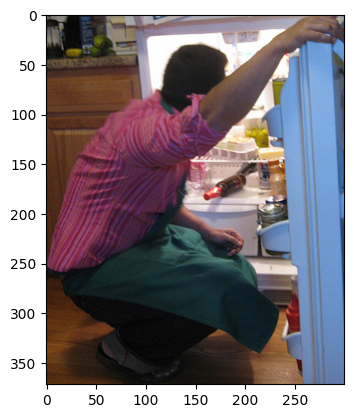

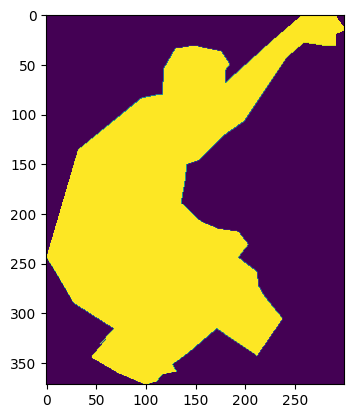

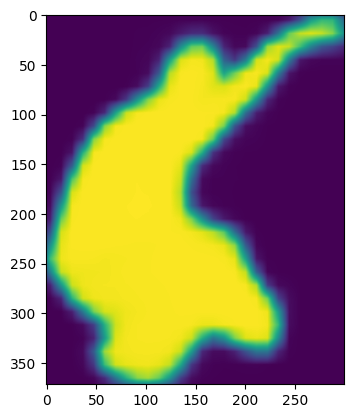

tensor(0.9277, dtype=torch.float16)


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as tvtf
import torch
f = h5py.File("/data/fast/venkatesh/iou_prediction/DATA/iou_prediction/Validation/0.h5", "r")

image = np.array(f.get("image"))
image = torch.from_numpy(image)
plt.imshow(tvtf.to_pil_image(image))
plt.show()

image = np.array(f.get("gt_mask"))
image = torch.from_numpy(image)
plt.imshow(tvtf.to_pil_image(image))
plt.show()

image = np.array(f.get("pred_mask"))
image = torch.from_numpy(image)
plt.imshow(tvtf.to_pil_image(image))
plt.show()

image = np.array(f.get("predicted_iou"))
image = torch.from_numpy(image)
print(image)

In [3]:
image

<HDF5 dataset "image": shape (3, 372, 300), type "<f2">